# Data preparation

We combine the data, convert the labels for classification and apply augmentation

In [10]:
import os, sys, math, json
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

np.random.seed(0)

IMAGE_SIZE = [32, 32]

Tensorflow version 2.7.0


In [11]:
df = pd.read_json('../data/labelled_data/prepared-samples-binary.json')

y = df['label'].to_numpy()
X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [12]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [13]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 32, 32, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 32, 32, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_1 (Dropout)            (None, 32, 32, 32)   0           ['batch_normalization_16[0]

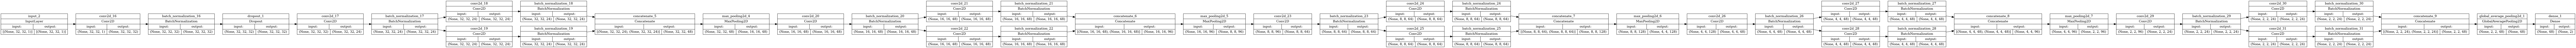

In [14]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/10
8/8 [==============================] - 5s 433ms/step - loss: 0.7455 - accuracy: 0.5583 - val_loss: 0.6614 - val_accuracy: 0.6500
Epoch 2/10
8/8 [==============================] - 2s 268ms/step - loss: 0.6821 - accuracy: 0.5583 - val_loss: 0.7693 - val_accuracy: 0.3500
Epoch 3/10
8/8 [==============================] - 2s 299ms/step - loss: 0.6996 - accuracy: 0.5583 - val_loss: 0.8333 - val_accuracy: 0.3250
Epoch 4/10
8/8 [==============================] - 2s 247ms/step - loss: 0.6584 - accuracy: 0.6000 - val_loss: 0.7237 - val_accuracy: 0.4000
Epoch 5/10
8/8 [==============================] - 3s 334ms/step - loss: 0.6073 - accuracy: 0.6917 - val_loss: 0.6523 - val_accuracy: 0.5750
Epoch 6/10
8/8 [==============================] - 3s 346ms/step - loss: 0.6312 - accuracy: 0.6250 - val_loss: 0.7683 - val_accuracy: 0.5000
Epoch 7/10
8/8 [==============================] - 2s 306ms/step - loss: 0.5732 - accuracy: 0.7000 - val_loss: 1.0599 - val_accuracy: 0.3500
Epoch 8/10
8/8 [====

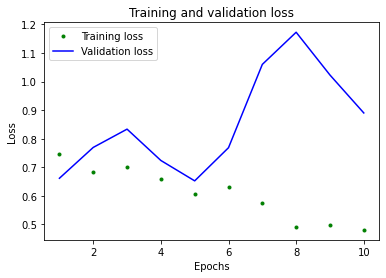

Test loss: 0.9009276628494263 / Test accuracy: 0.375


In [15]:
# Fit the model
EPOCHS = 10
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("squeezenet-eval.png")
plt.show()

# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [16]:
# make and show single prediciton
%matplotlib inline

n=4 # pics per row

label = {1: 'Human',
         0: 'No Human'}

pred = model.predict(X_test)

classes = np.argmax(pred, axis = 1)

print(classes)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1]


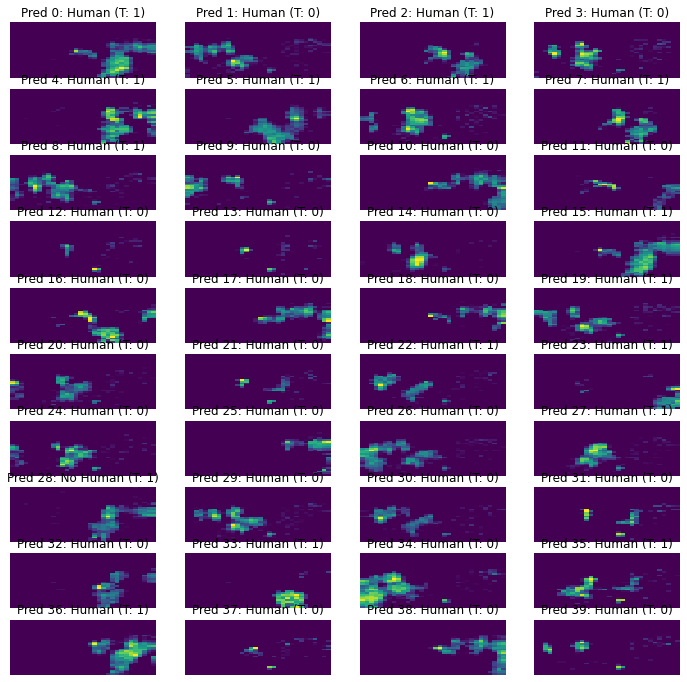

In [17]:
# Print predictions
fig, axes = plt.subplots(nrows=int(len(X_test)/n), ncols=n, figsize=(n*3, n*3), num='Predictions')
for ax, idx in zip(axes.reshape(-1), range(len(X_test))): 
    ax.set_axis_off()
    ax.set_title('Pred %i: %s (T: %i)' % (idx, label[classes[idx]], y_test[idx]))
    ax.imshow(X_test[idx].reshape(32, 32), interpolation='nearest', aspect='auto')

In [18]:
# Export saved model
tf.keras.models.save_model(model, "squeezenet-binary.h5")